### **Application of Convolution Networks to Image Data**
Downloading the data

In [8]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle competitions download dogs-vs-cats

 97% 788M/812M [00:03<00:00, 242MB/s]
100% 812M/812M [00:03<00:00, 234MB/s]


In [12]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

Inserting Images into Training, Validation and Test Directories.

In [13]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

### 1. Building a Model with Training Sample of 1000 and  Test & Validation Samples of 500 each.

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory

# Selecting Train, Validation and Test sets

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

train_set = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_set = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_set = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_set = dataset.batch(32)
for i, element in enumerate(batched_set):
    print(element.shape)
    if i >= 2:
        break

reshaped_set = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_set):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_set:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building and Executing the Model.

Epoch 1/20
63/63 [==============================] - 110s 2s/step - loss: 0.8039 - accuracy: 0.5020 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 108s 2s/step - loss: 0.7122 - accuracy: 0.5285 - val_loss: 0.6901 - val_accuracy: 0.5150
Epoch 3/20
63/63 [==============================] - 109s 2s/step - loss: 0.7285 - accuracy: 0.5365 - val_loss: 0.8130 - val_accuracy: 0.5090
Epoch 4/20
63/63 [==============================] - 109s 2s/step - loss: 0.7040 - accuracy: 0.6265 - val_loss: 0.6164 - val_accuracy: 0.6470
Epoch 5/20
63/63 [==============================] - 108s 2s/step - loss: 0.6405 - accuracy: 0.6575 - val_loss: 0.6066 - val_accuracy: 0.6600
Epoch 6/20
63/63 [==============================] - 107s 2s/step - loss: 0.6095 - accuracy: 0.6790 - val_loss: 0.6538 - val_accuracy: 0.6140
Epoch 7/20
63/63 [==============================] - 108s 2s/step - loss: 0.5889 - accuracy: 0.6885 - val_loss: 1.7365 - val_accuracy: 0.5070
Epoch 8/20
63

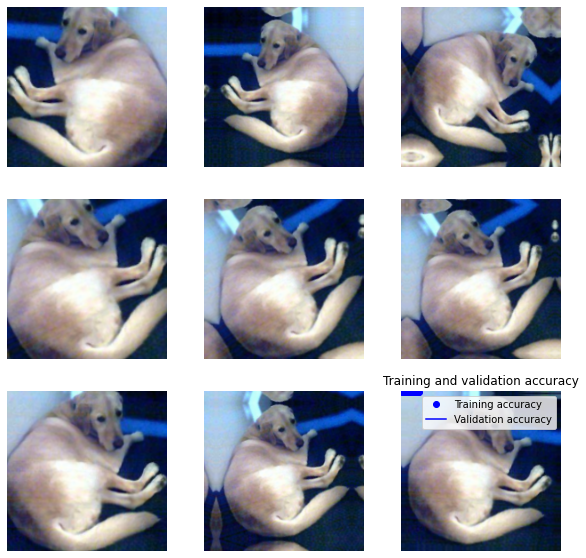

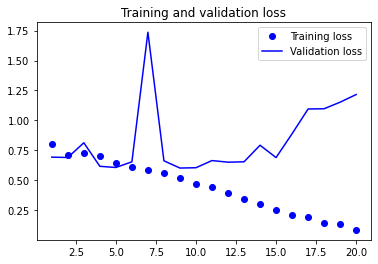

32/32 [==============================] - 14s 421ms/step - loss: 0.6252 - accuracy: 0.7010
Test accuracy: 0.701


In [15]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Printing Augmented Images of a Random Input Image

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Building Model Structure

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, 
        monitor="val_loss")
]

# Training the Model

history = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=callbacks)


# Plotting the Accuracy and Loss curves

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing Model and Printing the Output

model.test = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = model.test.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

### 2. Building new Model by Increasing the Training Sample with Validation and Test Samples remaining Same.

Diving Input into Training, Validation and Test Datasets.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_2", start_index=0, end_index=3000)
make_subset("validation_2", start_index=3000, end_index=3500)
make_subset("test_2", start_index=3500, end_index=4000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Building and Executing the Model.

Epoch 1/20
188/188 [==============================] - 503s 3s/step - loss: 0.8402 - accuracy: 0.5308 - val_loss: 0.6727 - val_accuracy: 0.6300
Epoch 2/20
188/188 [==============================] - 501s 3s/step - loss: 0.6782 - accuracy: 0.6160 - val_loss: 0.6383 - val_accuracy: 0.6240
Epoch 3/20
188/188 [==============================] - 499s 3s/step - loss: 0.6374 - accuracy: 0.6637 - val_loss: 0.6601 - val_accuracy: 0.5810
Epoch 4/20
188/188 [==============================] - 493s 3s/step - loss: 0.6246 - accuracy: 0.6852 - val_loss: 0.5860 - val_accuracy: 0.7080
Epoch 5/20
188/188 [==============================] - 495s 3s/step - loss: 0.5997 - accuracy: 0.7018 - val_loss: 0.5819 - val_accuracy: 0.6940
Epoch 6/20
188/188 [==============================] - 500s 3s/step - loss: 0.5725 - accuracy: 0.7248 - val_loss: 0.5924 - val_accuracy: 0.6930
Epoch 7/20
188/188 [==============================] - 496s 3s/step - loss: 0.5481 - accuracy: 0.7387 - val_loss: 0.5375 - val_accuracy: 0.7340

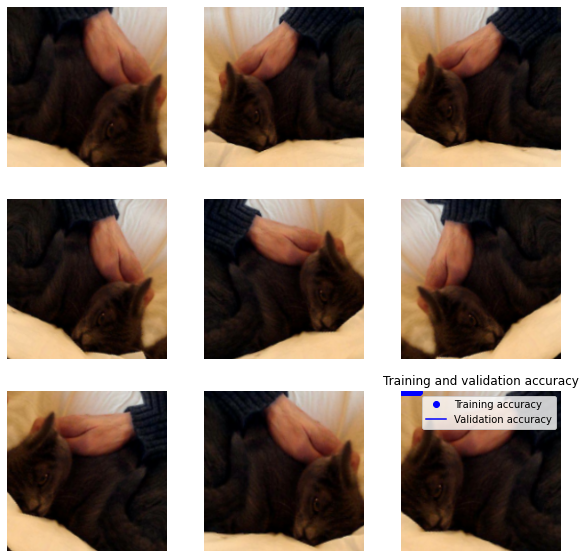

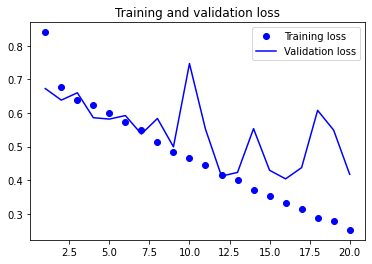

32/32 [==============================] - 25s 754ms/step - loss: 0.4705 - accuracy: 0.8150
Test accuracy: 0.815


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

# Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Plotting Augmented Images of Random Input Image

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Building Model Structure

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compiling the Model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

# Callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

# Training the Model

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

# Plotting Validation and Loss Curves

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing the Model and Printing Output

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### 3. Building New Model to Increase Accuracy by Changing Sample Size.

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

# Choosing Training, Validation and Test Datasets

make_subset("train_3", start_index=0, end_index=10000)
make_subset("validation_3", start_index=10000, end_index=10500)
make_subset("test_3", start_index=10500, end_index=11000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Building and Executing the Model.

Epoch 1/20
625/625 [==============================] - 986s 2s/step - loss: 0.7215 - accuracy: 0.6012 - val_loss: 0.5957 - val_accuracy: 0.7070
Epoch 2/20
625/625 [==============================] - 990s 2s/step - loss: 0.5871 - accuracy: 0.7095 - val_loss: 0.5123 - val_accuracy: 0.7580
Epoch 3/20
625/625 [==============================] - 992s 2s/step - loss: 0.5058 - accuracy: 0.7681 - val_loss: 0.4665 - val_accuracy: 0.8000
Epoch 4/20
625/625 [==============================] - 992s 2s/step - loss: 0.4518 - accuracy: 0.8057 - val_loss: 0.4386 - val_accuracy: 0.8090
Epoch 5/20
625/625 [==============================] - 992s 2s/step - loss: 0.4075 - accuracy: 0.8300 - val_loss: 0.4117 - val_accuracy: 0.8310
Epoch 6/20
625/625 [==============================] - 995s 2s/step - loss: 0.3745 - accuracy: 0.8486 - val_loss: 0.3539 - val_accuracy: 0.8550
Epoch 7/20
625/625 [==============================] - 993s 2s/step - loss: 0.3439 - accuracy: 0.8621 - val_loss: 0.3221 - val_accuracy: 0.8750

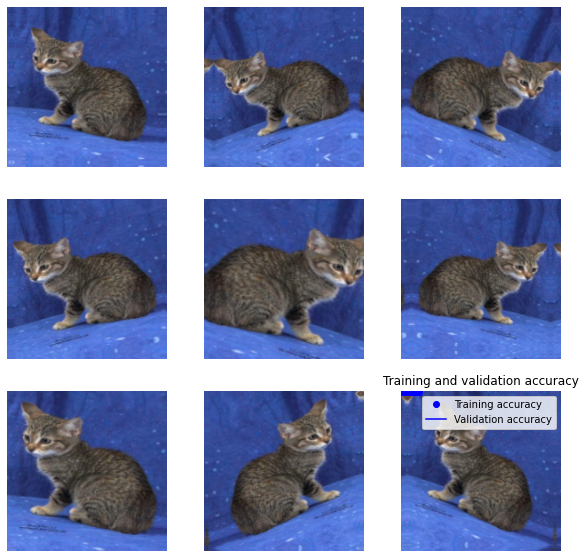

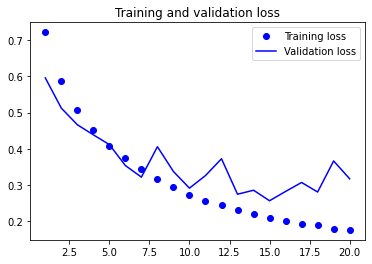

32/32 [==============================] - 15s 466ms/step - loss: 0.3039 - accuracy: 0.8890
Test accuracy: 0.889


In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

# Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
# Plotting Augmented Images of Random Input Image

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Building Model Structure

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compiling the Model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

# Callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

# Training the Model

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

# Printing Accuracy and Loss Curves

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Executing and Printing Output of the Model

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### 4. Using a Pretrained Convolution Network to Build a New Model

Implementing the Model with Training Sample of 2000, Validation & Test Samples of 1000 each and using VGG16 Architecture.

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15
625/625 [==============================] - 997s 2s/step - loss: 0.1720 - accuracy: 0.9466 - val_loss: 0.3419 - val_accuracy: 0.9080
Epoch 2/15
625/625 [==============================] - 997s 2s/step - loss: 0.1710 - accuracy: 0.9487 - val_loss: 0.3350 - val_accuracy: 0.8960
Epoch 3/15
625/625 [==============================] - 994s 2s/step - loss: 0.1700 - accuracy: 0.9496 - val_loss: 0.4132 - val_accuracy: 0.9070
Epoch 4/15
625/625 [==============================] - 996s 2s/step - loss: 0.1649 - accuracy: 0.9496 - val_loss: 0.3534 - val_accuracy: 0.9090
Epoch 5/15
625/625 [==============================] - 992s 2s/step - loss: 0.1678 - accuracy: 0.9517 - val_loss: 0.3767 - val_accuracy: 0.9140
Epoch 6/15
625/625 [==============================] - 992s 2s/step - loss: 0.1674 - accuracy: 0.9506 - val_loss: 0.2831 - val_accuracy: 0.9040
Epoch 7/15
625/625 [==============================] - 995s 2s/step - loss: 0.

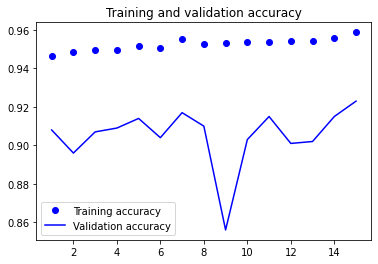

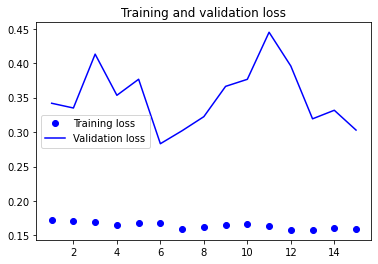

32/32 [==============================] - 14s 428ms/step - loss: 0.3226 - accuracy: 0.9020
Test accuracy: 0.902


In [18]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory

# Applying the VGG16 Convolutional Base

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding Data Augmentation Stage and a Classifier to the Convolutional Base

#Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)

# Fine-tuning the model

model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Using early stopping to stop optimization when it isn't helping any more

early_stopping_monitor = EarlyStopping(patience=10)

# Callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

# Training the Model

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

# Plotting the Accuracy and Validation Loss

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Executing and Printing the Model Output

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### **Summary**
From the above outputs of three models built from scratch, we can see that there is an increase in the accuracy of the model with increase in training sample size. This shows that more data is always good for increase in training of the data and thus helps in accuracy.

For each of the below models, I chose epoch sizes of 20 for the first 3 models and 15 for model 4 where we use a pretrained network for classification.

1. Sample sizes of 1000 for Training and 500 each for Validation and Test sets. For this model, the test accuracy was 70.10 which is not very acceptable. This model was also built with only data augmentation for better data and no additional optimization techniques were used. Hence, the low accuracy value.

2. Increasing Training samples and using the previously determined sample sizes for Validation and Test sets. For this model, the test accuracy output was 81.50. Starting this model, I have started including learning rate and dropout techniques for optimization purposes. Compared to the earlier model, the new model with higher sample size and optimizers used given better accuracy.

3. Changing training sample size again for better performance of the model. For this model, the test accuracy output was 88.90. As compared to the previous model, increase in training sample size has definitely helped in increased classifying accuracy of the model.

4. Performing the previous steps using a Pretrained Network. For this model, VGG16 Pretrained Convnet was used. The use of pretrained network further increased the accuracy of model with same sample sizes as previous model, though the number of epochs selected was only 15. Hence, we can observe that a pretrained network can be helpful in building a better model with reduced input into building the model and increased accuracy due to vast training given to the pretrained network earlier.